# Library Import

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Data Load

In [3]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp -r /content/drive/MyDrive/DATASET .

# Data Preprocessing

In [26]:
train_dir = "/content/DATASET/TRAIN/"
test_dir = "/content/DATASET/TEST/"

In [35]:
img_width = 224
img_height = 224
batch_size = 16
model_dir = "./model"
checkpoint = "model_checkpoint_best_.keras"
checkpoint_path = os.path.join(model_dir, checkpoint)

In [36]:
os.makedirs(model_dir, exist_ok=True)

In [37]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle="True"
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 688 images belonging to 26 classes.
Found 159 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [38]:
print(train_generator.class_indices)
print(train_generator.samples)

{'Aceh_Pintu_Aceh': 0, 'Bali_Barong': 1, 'Bali_Merak': 2, 'DKI_Ondel_Ondel': 3, 'Jawa_Barat_Megamendung': 4, 'Jawa_Tengah_Batik_Lasem': 5, 'Jawa_Timur_Pring': 6, 'Kalimantan_Barat_Insang': 7, 'Kalimantan_Dayak': 8, 'Lampung_Gajah': 9, 'Madura_Mataketeran': 10, 'Maluku_Pala': 11, 'NTB_Lumbung': 12, 'Palembang_Songket': 13, 'Papua_Asmat': 14, 'Papua_Cendrawasih': 15, 'Papua_Tifa': 16, 'Solo_Parang': 17, 'Solo_Sidoluhur': 18, 'Solo_Sogan': 19, 'Solo_Truntum': 20, 'Sulawesi_Selatan_Lontara': 21, 'Sumatera_Barat_Rumah_Minang': 22, 'Sumatera_Utara_Boraspati': 23, 'Yogyakarta_Kawung': 24, 'Yogyakarta_Sidomukti': 25}
688


# Model Initialization

In [39]:
base_model = EfficientNetB0(include_top=False, input_shape=(img_width, img_height,3), weights='imagenet')
base_model.trainable = False

In [40]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [41]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=5,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [42]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8),
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]

# Model Training

In [43]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.0346 - loss: 4.9033
Epoch 1: val_accuracy improved from -inf to 0.05660, saving model to ./model/model_checkpoint_best_.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 50s 611ms/step - accuracy: 0.0347 - loss: 4.9028 - val_accuracy: 0.0566 - val_loss: 3.3230 - learning_rate: 6.5939e-05
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.0575 - loss: 4.6574
Epoch 2: val_accuracy improved from 0.05660 to 0.09434, saving model to ./model/model_checkpoint_best_.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step - accuracy: 0.0574 - loss: 4.6574 - val_accuracy: 0.0943 - val_loss: 3.2433 - learning_rate: 6.2597e-05
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.0565 - loss: 4.3669
Epoch 3: val_accuracy improved from 0.09434 to 0.15723, saving model to ./model/model_checkpoint_best_.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.0568 - loss: 4.3654 - val_accuracy: 0.1572 - val_loss: 3.1309 - learni

In [50]:
base_model.trainable = True

fine_tune_at = 200  # Unfreeze layers from 200 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.2265 - loss: 3.1158
Epoch 1: val_accuracy did not improve from 0.59119
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 610ms/step - accuracy: 0.2272 - loss: 3.1140 - val_accuracy: 0.5031 - val_loss: 2.0348 - learning_rate: 1.0000e-05
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2759 - loss: 3.0569
Epoch 2: val_accuracy did not improve from 0.59119
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.2755 - loss: 3.0580 - val_accuracy: 0.5283 - val_loss: 2.0573 - learning_rate: 1.0000e-05
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.2942 - loss: 3.0479
Epoch 3: val_accuracy did not improve from 0.59119
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accuracy: 0.2940 - loss: 3.0471 - val_accuracy: 0.4906 - val_loss: 2.0322 - learning_rate: 1.0000e-05
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2917 - loss: 2.8582
Epoch 4: val_accuracy did not improve from 0.59119
43/43 ━━━━━━━━

# Evaluation

In [44]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5541 - loss: 1.7599
Validation Loss: 1.809, Validation Accuracy: 52.20%
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5703 - loss: 1.6350
Test Loss: 1.625, Test Accuracy: 58.17%


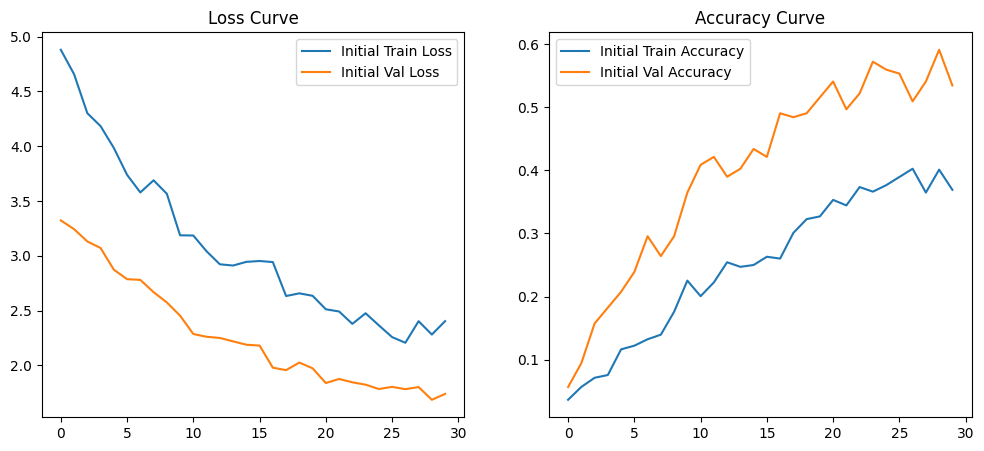

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step


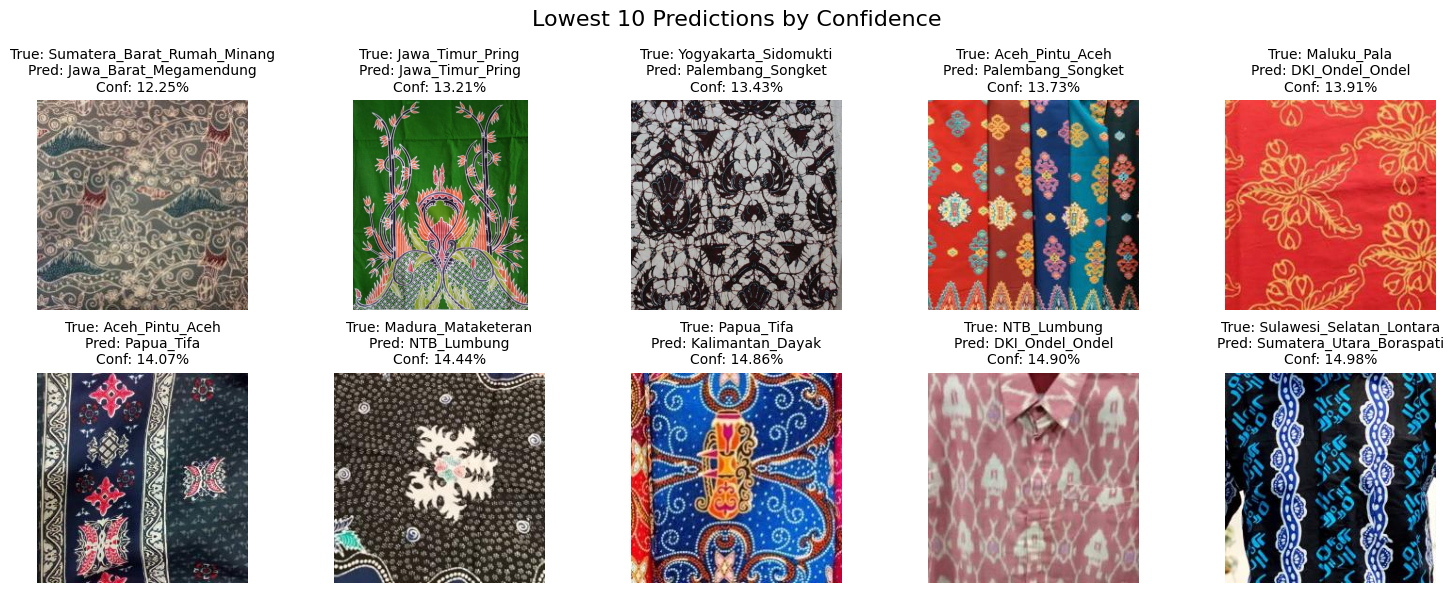

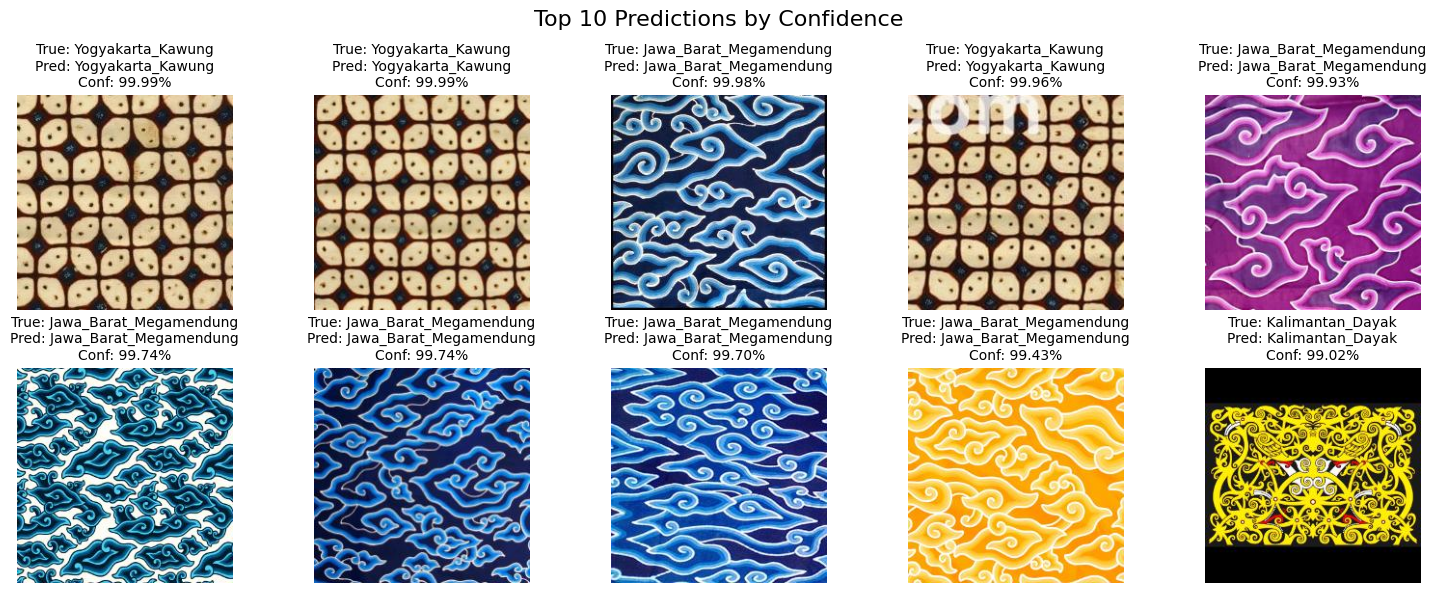

In [46]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")

# Save Model

In [ ]:
# SavedModel
model.export('model_saved')

# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# TFJS
tfjs_target_dir = 'tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_target_dir)